# Определение жанра по изображению обложки музыкального диска

### Описание проекта
Pet-проект, чтобы потренировать навыки, приобрести новые и нескучно провести время.
Очевидно, что оформление музыкального альбома как-то связано с его содержанием. Но насколько связано? Как подтвердить это, опираясь на данные? И чем это может быть полезно?

### Основная задача
Необходимо разработать модель, которая определит жанр музыкального альбома по изображению его обложки.

### Данные
Изображения в формате PNG, упакованные в zip-архивы. Имя архива соответствует музыкальному жанру. Каждый zip-архив содержит папку с изображениями музыкальных обложек соответствующего жанра.

### Метрика
Оценка качества модели будет производиться с использованием метрики **Accuracy**

### Рекомендуемый план реализации
- Ознакомление с данными.
- Предварительная обработка данных.
- Определение целевой метрики.
- Подготовка данных для нейронной сети.
- Обучение нейронной сети.
- Расчет и сравнение метрик.
- Анализ финальной модели.
- Подготовка отчета по исследованию.

### Рекомендуемый стек
**python, sklearn, faiss, pytorch, torchvision, fastai.**

### Дополнительные задачи
- Кластеризация: исследовать, какие жанры лучше выделяются на фоне других, а какие – трудноразделимы.
- API MusicBrainz: расширение датасета новыми изображениями. Можно расширить список жанров и использовать обратную сторону обложки.
- OCR + NLP: извлечь текст из изображения и обогатить решение применением NLP.
- Создать рекомендательную систему в миниатюре, опираясь на изображения.
- Streamlit оформить классификатор жанров или рекомендательную систему в виде веб-приложения.

# Загрузка необходимых библиотек и данных

### Импорт библиотек

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install timm
!pip install faiss-gpu

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

import torch
import faiss
import fastai
from fastai.vision.all import *

import timm
from torch.nn.init import kaiming_normal_

### Параметры отображения

In [5]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

### Чтение файла с данными

In [6]:
# Абсолютный путь
data_path = 'drive/MyDrive/music-album/data'

# Пути к директориям с фотографиями
directories = [
    "anime",
    "black metal",
    "classical",
    "country",
    "disco",
    "edm",
    "jazz",
    "pop",
    "rap",
    "reggae"
]

Код нижe загружает изображения из каждого файла, добавляет их в список data, присваивая каждому изображению соответствующий жанр, а затем создает DataFrame. Сгенерим сразу два признака с изображениями, с указанием директории для обучения и без для анализа, нужно изучить каждое изображение по отдельности, и проверить на наличие дублей:

In [7]:
# Создание списка файлов с указанием пути к изображениям, их жанру и именам
file_list = []
for directory in directories:
    file_names = os.listdir(os.path.join(data_path, directory))
    file_list.extend([(os.path.join(data_path, directory, file),
                       directory, os.path.basename(file)) for file in file_names])

# Создание датафрейма
df = pd.DataFrame(file_list, columns=['path_image', 'genre', 'image'])

# Вывод первых строк датафрейма
df.head()

,path_image,genre,image
0,drive/MyDrive/music-album/data/anime/79082778-c36c-42c2-af2b-1bbe5a062028.png,anime,79082778-c36c-42c2-af2b-1bbe5a062028.png
1,drive/MyDrive/music-album/data/anime/3f648d4c-b0b1-41db-b732-1d0164edbac0.png,anime,3f648d4c-b0b1-41db-b732-1d0164edbac0.png
2,drive/MyDrive/music-album/data/anime/9d2596ec-6dff-4fd8-9408-e7bc795e8548.png,anime,9d2596ec-6dff-4fd8-9408-e7bc795e8548.png
3,drive/MyDrive/music-album/data/anime/b040f102-49f6-4d68-9e45-ba7498ea23b2.png,anime,b040f102-49f6-4d68-9e45-ba7498ea23b2.png
4,drive/MyDrive/music-album/data/anime/df80f80d-ac35-4b3e-ab9e-d33f31331fd7.png,anime,df80f80d-ac35-4b3e-ab9e-d33f31331fd7.png


In [8]:
# Сохраняем DataFrame в формате CSV
df.to_csv("photos_genres.csv", index=False)

В итоге у нас есть DataFrame, содержащий изображения
музыкальных альбомов с соответствующими названиями жанров.

# EDA

## Функции

In [9]:
def data_review(data):
    """
    Функция для обзора данных.

    Функция выводит общую информацию о данных: обнаруженные пропуски, их процентное соотношение по каждому столбцу,
    общее количество пропущенных значений, количество явных дубликатов и основные статистические характеристики данных.

    Args:
    data (DataFrame): Данные для анализа в формате DataFrame.

    Returns:
    None
    """

    print('\033[1m \nОбщая информация: \n\033[0m \n')
    data.info()
    display(data.sample(5))

    print('\n\033[1m Пропуски в данных: \033[0m \n')
    missing_percentage = (data.isna().sum() / len(data)) * 100
    display(pd.DataFrame({'Пропуски': data.isna().sum(), 'Процент пропусков': missing_percentage}))

    print('\n\033[1m Всего пропущенных значений: \033[0m', data.isna().sum().sum())
    print('\n\033[1m Количество явных дублей: \033[0m', data.duplicated().sum())

    print('\n\033[1m Основные статистические характеристики данных: \033[0m')
    display(data.describe().T)


In [10]:
def plot_genre_distribution(df):
    """
    Строит столбчатую диаграмму для распределения жанров.

    Args:
    df (DataFrame): DataFrame с данными о жанрах. Должен содержать столбец 'genre'.

    Returns:
    None
    """
    # Получаем распределение жанров
    genre_counts = df['genre'].value_counts()

    # Устанавливаем стиль seaborn
    sns.set(style="whitegrid")

    # Строим столбчатую диаграмму
    plt.figure(figsize=(10, 6))
    sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis", alpha=.8)
    plt.title('Distribution of Genres', fontsize=16)
    plt.xlabel('Genre', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.xticks(rotation=45)
    plt.show()

## Разведочный анализ

In [11]:
data_review(df)

 
Общая информация: 
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7800 entries, 0 to 7799
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path_image  7800 non-null   object
 1   genre       7800 non-null   object
 2   image       7800 non-null   object
dtypes: object(3)
memory usage: 182.9+ KB


,path_image,genre,image
165,drive/MyDrive/music-album/data/anime/58986aa7-1b2f-406d-94e0-75a832fa7f2c.png,anime,58986aa7-1b2f-406d-94e0-75a832fa7f2c.png
1042,drive/MyDrive/music-album/data/anime/9e08d548-30e0-42cd-b2af-df4d5104f681.png,anime,9e08d548-30e0-42cd-b2af-df4d5104f681.png
4637,drive/MyDrive/music-album/data/edm/a405c20e-5d43-415b-a3fc-5ff794b77a39.png,edm,a405c20e-5d43-415b-a3fc-5ff794b77a39.png
1111,drive/MyDrive/music-album/data/anime/39ddb231-ae6b-48b3-924f-10b77a0a2246.png,anime,39ddb231-ae6b-48b3-924f-10b77a0a2246.png
2908,drive/MyDrive/music-album/data/country/a513b097-04e4-462c-8d96-3fdcfa227117.png,country,a513b097-04e4-462c-8d96-3fdcfa227117.png



 Пропуски в данных:  



,Пропуски,Процент пропусков
path_image,0,0.00
genre,0,0.00
image,0,0.00



 Всего пропущенных значений:  0

 Количество явных дублей:  0

 Основные статистические характеристики данных: 


,count,unique,top,freq
path_image,7800,7800,drive/MyDrive/music-album/data/reggae/6b8b0fbf-07ba-46a1-9ca1-2b21b24ecb7b.png,1
genre,7800,10,country,1486
image,7800,7796,9123d325-bf8e-4423-be98-98478dccee20.png,2


Из основных статистических характеристик данных мы можем сделать следующие выводы:

1. **Количество записей (count):** 7800
  
2. **Уникальные значения (unique):**
   - Для столбца `image` 7796 уникальных значений, значит некоторые изображения повторяются
   - Для столбца `genre` 10 уникальных жанров

3. **Часто встречающиеся значения (top):**
   - Самое часто встречающееся изображение имеет имя файла "9123d325-bf8e-4423-be98-98478dccee20.png"
   - Самый часто встречающийся жанр - `country`

4. **Частота часто встречающихся значений (freq):**
   - "9123d325-bf8e-4423-be98-98478dccee20.png" повторяется 2 раза
   - `country` встречается 1486 раз

## Исследовательский анализ

Напечатаем повторяющиеся изображения:

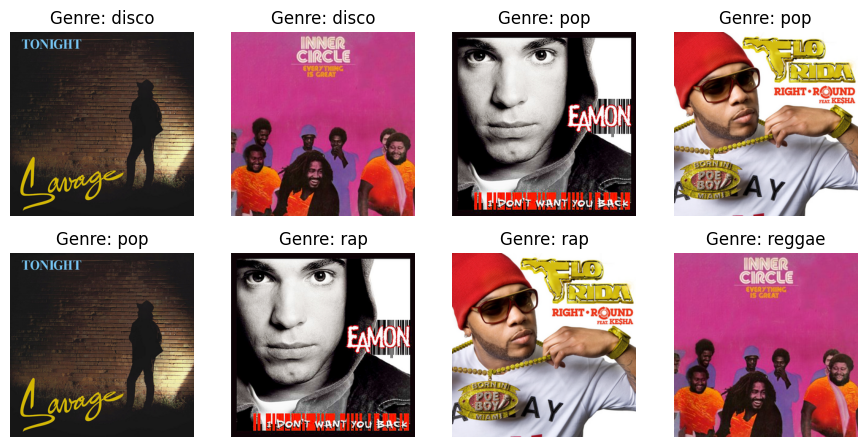

In [12]:
# Создаем фигуру для отображения изображений
fig = plt.figure(figsize=(9, 9))

# Фильтруем дублирующиеся изображения
duplicated_images = df.groupby('image').filter(lambda x: len(x) > 1)

# Выводим изображения и их жанры
for i, (_, row) in enumerate(duplicated_images.iterrows(), start=1):

    # Составляем путь к изображению
    image_path = os.path.join(data_path, row['genre'], row['image'])

    # Загружаем и отображаем изображение
    image = plt.imread(image_path)
    fig.add_subplot(4, 4, i)
    plt.imshow(image)
    plt.title('Genre: {}'.format(row['genre']))
    plt.axis('off')

# Показываем изображения
plt.tight_layout()
plt.show()


По итогу, это одинаковые обложки для разных жанров. Удаляем все строки, содержащие дубли в `image` и сбрасываем индексы:

In [13]:
# Удаление дубликатов по признаку "image"
df = df.drop_duplicates(subset='image').reset_index(drop=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7796 entries, 0 to 7795
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path_image  7796 non-null   object
 1   genre       7796 non-null   object
 2   image       7796 non-null   object
dtypes: object(3)
memory usage: 182.8+ KB


Отлично, дублирующиеся изображения удалены

Наглядно изучим распределение жанров:

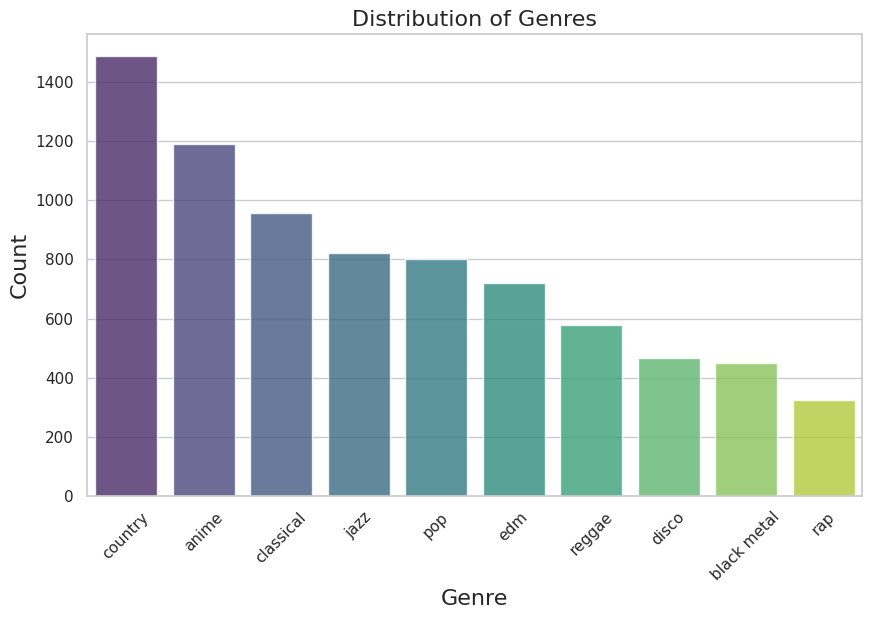

In [15]:
# График распределения жанров
plot_genre_distribution(df)

- MAX: `country`, `anime`, `classical`
- MIN: `disco`, `black metal`, `rap`

Признак `image` больше ни к чему, его удаляем: 

In [16]:
# Удаление признаков
df.drop(columns=['image'], inplace=True)

In [17]:
df.head()

,path_image,genre
0,drive/MyDrive/music-album/data/anime/79082778-c36c-42c2-af2b-1bbe5a062028.png,anime
1,drive/MyDrive/music-album/data/anime/3f648d4c-b0b1-41db-b732-1d0164edbac0.png,anime
2,drive/MyDrive/music-album/data/anime/9d2596ec-6dff-4fd8-9408-e7bc795e8548.png,anime
3,drive/MyDrive/music-album/data/anime/b040f102-49f6-4d68-9e45-ba7498ea23b2.png,anime
4,drive/MyDrive/music-album/data/anime/df80f80d-ac35-4b3e-ab9e-d33f31331fd7.png,anime


## Итог

По итогу проведенного исследования были изучены повторяющиеся значения в `image` и распределение жанров. 

**Дубли в данных:** удалены, итоговое количество строк **7796**

**Итоговые признаки:**
- `path_image` - имена изображений с указанием директории
- `genre` - жанр музыкального альбома

# Подготовка и обучение

#### Классификация по нескольким меткам - с использованием высокоуровневого API

Для начала подготовим загрузчик данных, с указанием необходимых параметров:

In [18]:
#df = df.sample(n=2000, random_state=654321)

In [19]:
# Загрузка данных из DataFrame
dls = ImageDataLoaders.from_df(df, path='/content',
                               valid_pct=0.2,
                               seed=654321,
                               fn_col=0,
                               suff='',
                               label_col=1,
                               img_cls=fastai.vision.core.PILImage,
                               bs=64,
                               shuffle=True
                               )


На этом этапе создается объект `ImageDataLoaders`, который предоставляет удобный интерфейс для: автоматической предобработки изображений, пометку данных на train/valid, определение размеров батчей и прочее

С помощью встроенной функции выведем несколько изображений, для наглядности: 

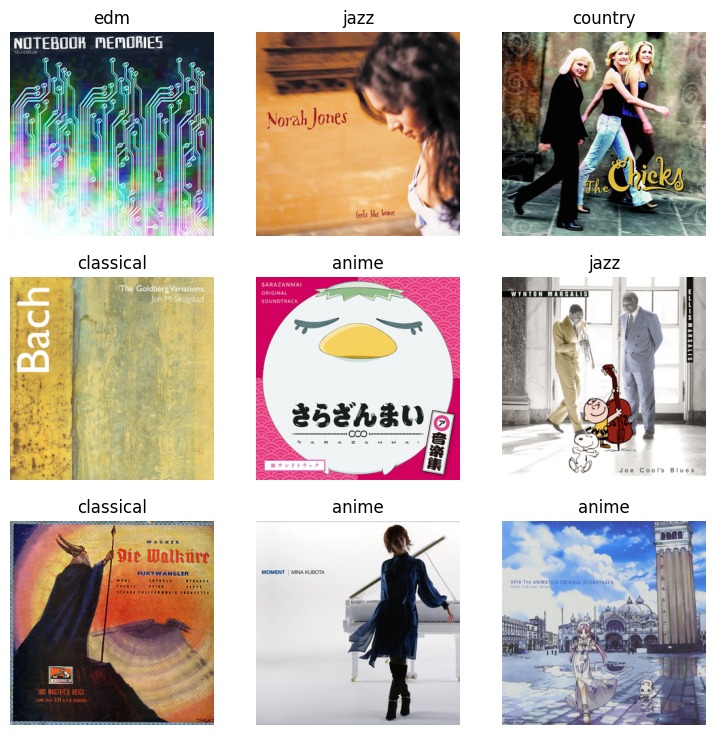

In [20]:
dls.show_batch()

Следующим этапом нужно определить такие компоненты как:
- архитектуру нейронной сети
- функцию потерь
- метрику
- скорость обучения 
- метод инициализации весов модели и прочее

In [21]:
learn = vision_learner(dls,
                       arch='resnet50',                     
                       normalize=True,                      
                       pretrained=True,                     
                       loss_func=CrossEntropyLossFlat(),    
                       opt_func=Adam,
                       lr=0.001,
                       metrics=accuracy,
                       model_dir='models',
                       moms=(0.95, 0.85, 0.95),
                       init=kaiming_uniform_,
                       ps=0.5,
                       first_bn=True,
                       bn_final=False,
                       lin_first=False,
                       n_in=3)

- Используем предварительно подготовленную сверточную сеть глубиной 50 слоев
- Скорость обучения 0.001
- Функция потерь - кросс-энтропия
- Директория, в которой будут сохраняться модели `models`
- Количество входных каналов (RGB) `n_in=3` для цветных изображений
- Метрика для оценки качества модели - accuracy

## Callback
Сгенерим четыре колбэка, которые будут использоваться в процессе обучения

Важно учитывать что производные TrackerCallbacks (`SaveModelCallback, ReduceLROnPlateu и EarlyStoppingCallback`) имеют скорректированный порядок:

1. TrackerCallback
2. SaveModelCallback
3. ReduceLrOnPlateu
4. EarlyStoppingCallback

### TrackerCallback
Позволяет отслеживать изменение метрики во время обучения

In [22]:
cbs_tracker = TrackerCallback(monitor='valid_loss',
                              min_delta=0.001,
                              reset_on_fit=True)

`monitor` определяет метрику, которая будет отслеживаться, в данном случае `valid_loss`, а `min_delta` определяет минимальное изменение значимости

### SaveModelCallback
Этот колбэк сохраняет модель во время обучения, если метрика, указанная в `monitor`, улучшается. `fname` указывает имя файла, в который будет сохранена лучшая модель.


In [23]:
cbs_save = SaveModelCallback(monitor='valid_loss',
                             fname='best_model')

### ReduceLROnPlateau

Уменьшает скорость обучения (learning rate) в случае, если метрика, указанная в `monitor`, перестает улучшаться после указанного количества эпох `patience`. Это помогает модели сойтись к локальному минимуму. `factor` указывает на сколько будет уменьшена скорость обучения, а `min_lr` задает минимальное значение для скорости обучения.

In [24]:
# Регулирование скорости обучения
cbs_reduce = ReduceLROnPlateau(monitor='valid_loss',
                               min_delta=0.001,
                               patience=1,
                               factor=10.0,
                               min_lr=0,
                               reset_on_fit=True)

### EarlyStoppingCallback:

Колбэк останавливает обучение, если метрика, указанная в `monitor`, перестает улучшаться после указанного количества эпох `patience`. Способствует предотвращению переобучение модели.


In [25]:
cbs_stop = EarlyStoppingCallback(monitor='valid_loss',
                                 min_delta=0.01,
                                 patience=3)

## Обучение модели

In [26]:
# Обучение модели с использованием колбэка для сохранения модели
learn.fine_tune(epochs=12,
                base_lr=0.0001,
                freeze_epochs=4,
                lr_mult=100,
                pct_start=0.3,
                div=50.,
                div_final=100000,
                cbs=[cbs_tracker, cbs_reduce, cbs_stop, cbs_save],
                reset_opt=False,
                start_epoch=0)

epoch,train_loss,valid_loss,accuracy,time
0,3.554304,2.571539,0.169339,01:45
1,2.888720,1.989890,0.402181,01:42
2,2.266855,1.606929,0.517640,01:41
3,1.854735,1.518586,0.558050,01:41


Better model found at epoch 0 with valid_loss value: 2.5715394020080566.
Better model found at epoch 1 with valid_loss value: 1.9898897409439087.
Better model found at epoch 2 with valid_loss value: 1.6069291830062866.
Better model found at epoch 3 with valid_loss value: 1.5185855627059937.


epoch,train_loss,valid_loss,accuracy,time
0,1.643957,1.537613,0.552277,02:15
1,1.617618,1.416180,0.567030,02:13
2,1.546321,1.435975,0.568954,02:14
3,1.436138,1.380577,0.580500,02:14
4,1.354629,1.361319,0.592046,02:14
5,1.278877,1.271016,0.605516,02:14
6,1.212366,1.419069,0.604234,02:14
7,1.181394,1.343407,0.600385,02:13
8,1.111022,1.363381,0.607441,02:13


Better model found at epoch 0 with valid_loss value: 1.5376125574111938.
Better model found at epoch 1 with valid_loss value: 1.4161803722381592.
Epoch 2: reducing lr to 4.660655615523839e-06
Better model found at epoch 3 with valid_loss value: 1.3805769681930542.
Better model found at epoch 4 with valid_loss value: 1.3613193035125732.
Better model found at epoch 5 with valid_loss value: 1.271016001701355.
Epoch 6: reducing lr to 3.246110802597399e-06
Epoch 7: reducing lr to 2.3228155368784507e-06
Epoch 8: reducing lr to 1.4240188394330395e-06
No improvement since epoch 5: early stopping


Посмотрим на распределение функции потерь:

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

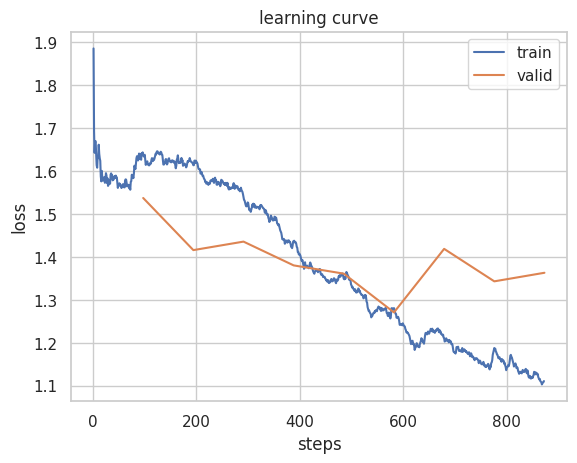

In [27]:
# Построение графика потерь
learn.recorder.plot_loss(skip_start=1)

По итогу лучший результат показывает epoch 5, со значением `valid_loss` равным 1.271016

Обучение было прервано EarlyStoppingCallback, так как в течении 3 эпох показатели не улучшались

Воспользуемся методом lr_find() и определим оптимальный диапазон значений для learning rate:


SuggestedLRs(valley=4.365158383734524e-05)

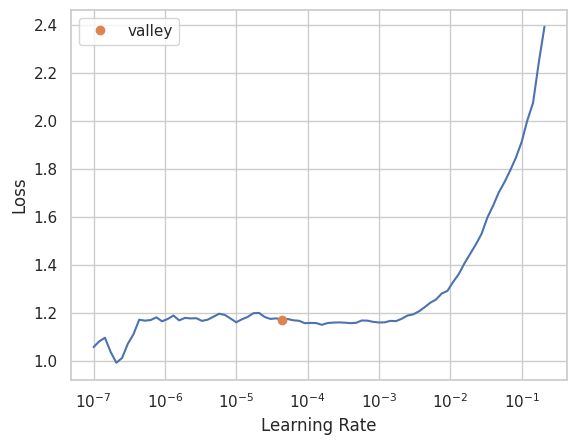

In [28]:
learn.lr_find()

Настройка оптимальной скорости обучения, позволяет найти баланс между достижением хороших результатов и быстротой сходимости модели. 

*Ранее функция показала значение SuggestedLRs(valley=0.0001) именно это значение и было использовано в процессе тюнинга, что в последствии помогло улучшить обобщающую способность (модель переобучалась и плохо подстраивалась под валидационную выборку)*

Пострим график изменения скорости обучения модели:

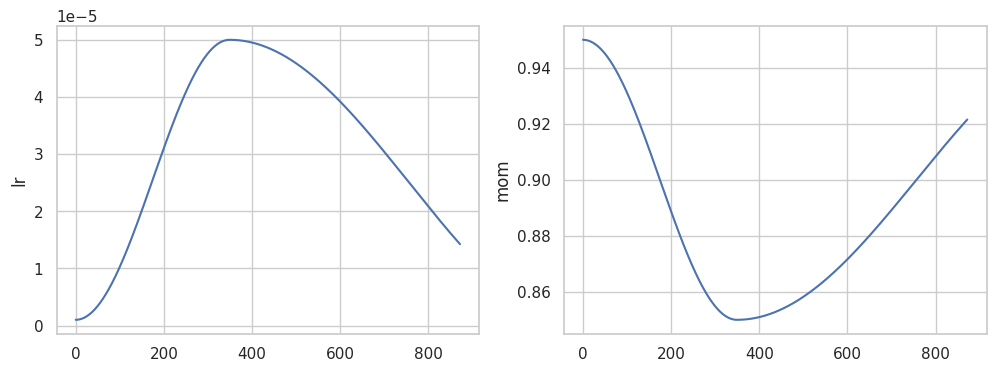

In [29]:
# Скорость обучения
learn.recorder.plot_sched()

- Импульс(mom) представляет собой инерцию, с которой модель движется вдоль градиента функции потерь
- Скорость обучения (lr) - это параметр, определяющий размер шага, с которым модель обновляет веса в процессе обучения. Он контролирует, насколько быстро или медленно модель сходится к оптимальным весам.
  
Чтобы достигнуть более стабильной сходимости и избежать колебаний в процессе обучения: при увеличении lr уменьшается mom и наоборот

Далее интерпретируем результаты модели, для этого будем использовать класс `ClassificationInterpretation`

In [30]:
# Создание объекта ClassificationInterpretation
interp = ClassificationInterpretation.from_learner(learn)

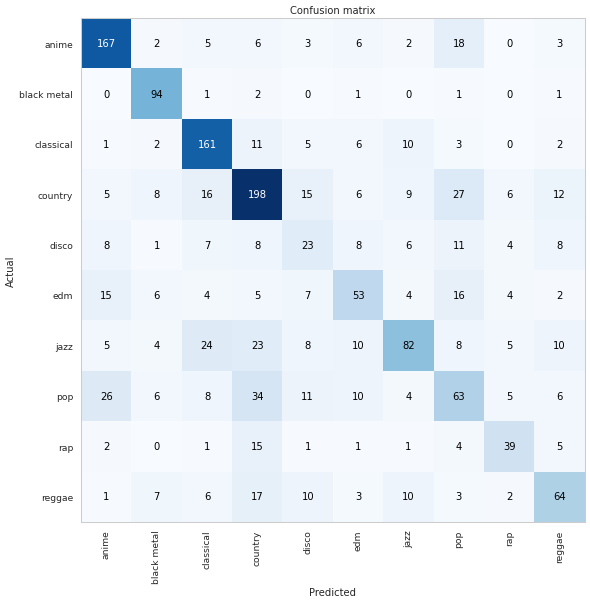

In [31]:
# Построение матрицы ошибок
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

Выведем список пар категорий, где модель допускает больше 10 ошибок:

In [32]:
# Наиболее популярные классы
interp.most_confused(min_val=10)

[('pop', 'country', 34),
 ('country', 'pop', 27),
 ('pop', 'anime', 26),
 ('jazz', 'classical', 24),
 ('jazz', 'country', 23),
 ('anime', 'pop', 18),
 ('reggae', 'country', 17),
 ('country', 'classical', 16),
 ('edm', 'pop', 16),
 ('country', 'disco', 15),
 ('edm', 'anime', 15),
 ('rap', 'country', 15),
 ('country', 'reggae', 12),
 ('classical', 'country', 11),
 ('disco', 'pop', 11),
 ('pop', 'disco', 11),
 ('classical', 'jazz', 10),
 ('jazz', 'edm', 10),
 ('jazz', 'reggae', 10),
 ('pop', 'edm', 10),
 ('reggae', 'disco', 10),
 ('reggae', 'jazz', 10)]

**Поп-музыка vs. Кантри** два жанра чаще всего путаются между собой, причем классификация в сторону жанра **Поп** происходит чаще (34 случая) по сравнению с жанром **Кантри** (27 случаев) 

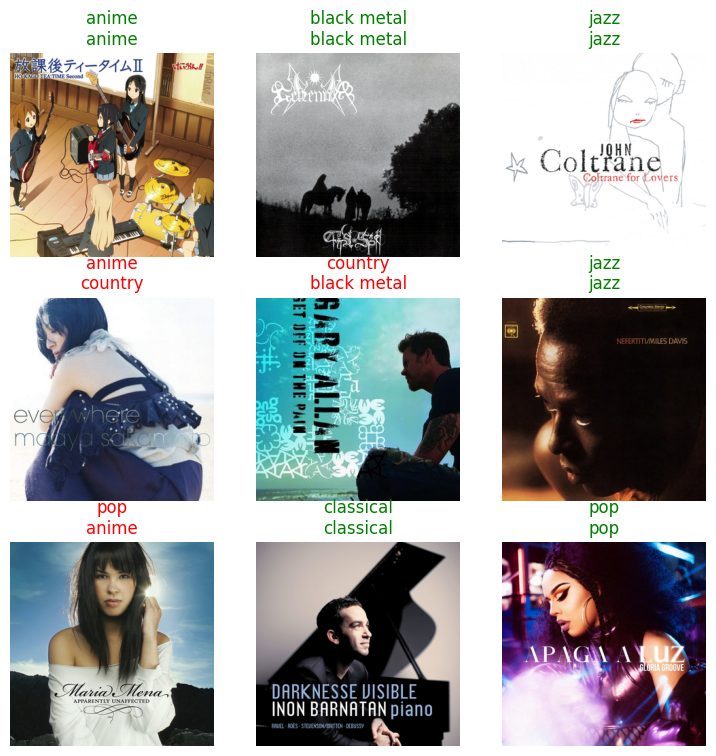

In [33]:
# Результаты (предсказания и метки) для нескольких изображений
interp.show_results(idxs=list(range(9)))

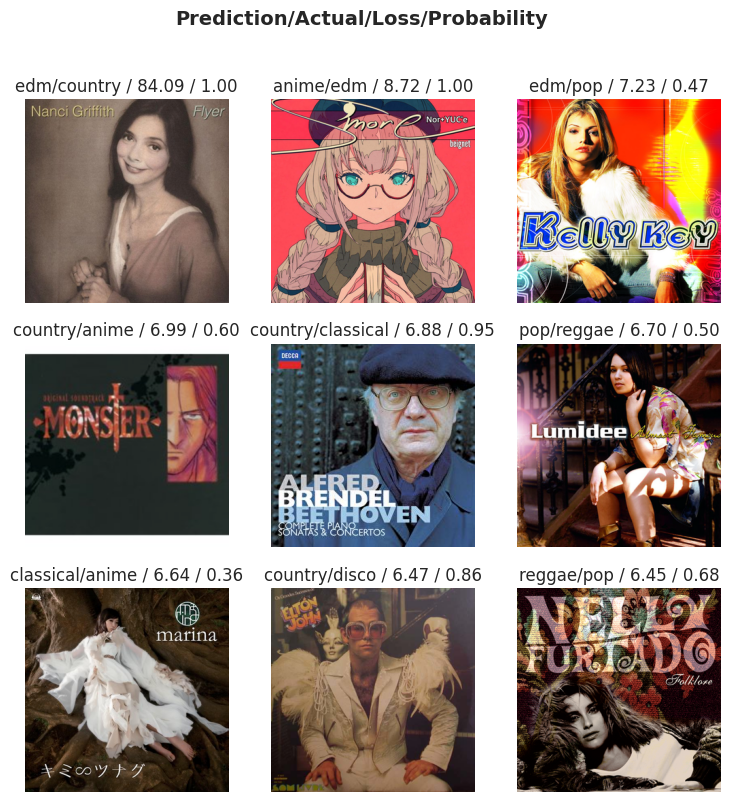

In [34]:
# График с наибольшими потерями
interp.plot_top_losses(k=9)

**edm/country/84.09/1.00**: Модель c вероятностью **84.09%** классифицировала изображение как **edm**, но фактически оно относится к **country**. Потери модели составили **1.00**

**anime/edm/8.72/1.00**: Модель неправильно классифицировала изображение как **anime** с вероятностью **8.72%**. Потери модели также составили **1.00**

In [35]:
# preds, targets, losses = learn.get_preds(with_loss=True)

# Отчет

**Задача** проекта состояла в разработке модели, которая определит жанр музыкального альбома по изображению его обложки.

**Проделанные шаги:**

**1. Загрузка необходимых библиотек и данных.** На данном этапе был выполнен импорт всех необходимых библиотек и подготовка данных, а именно: чтение данных с файлов, генерация признаков и датафрейма 

**2. EDA.** Разведочный и исследовательский анализ данных:
   - **Дубли в данных:** удалены, итоговое количество строк **7796**

   - **Итоговые признаки:**
      - `path_image` - имена изображений с указанием директории
      - `genre` - жанр музыкального альбома
        
**3. Подготовка и обучение.** 
```Python
- Модель обучена на базе предварительно подготовленной сверточной сети 'ResNet50'
- Функция потерь 'CrossEntropyLossFlat()'
- Метрика Accuracy
- Функция активации 'Adam'
- Скорость обучения 0.0001
- Зачения:

   epoch | train_loss |	valid_loss | accuracy | time
   --------------------------------------------------
    5    |   1.278877 | 1.271016   | 0.605516 | 02:14
```